Calculate correlation between features and the label (Total_Returns_NextYear).
Keep only the top 5 most correlated features 
SPLIT USING split_time_series_by_river

TOP_5FEATURES
RIVER ALAGNAK

XGBoost Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.5371
MSE  (Mean Squared Error):     5357056401245.84
MAPE (Mean Absolute % Error):  39.73%

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak only):
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R²   (R-squared):              -0.1759
MSE  (Mean Squared Error):     4098123944277.75
MAPE (Mean Absolute % Error):  38.34%

Random Forest (Log-Transformed Target, Alagnak, Top 5 Features):
R²   (R-squared):              -0.1759
MSE  (Mean Squared Error):     4098123944277.75
MAPE (Mean Absolute % Error):  38.34%

Random Forest Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              0.0279
MSE  (Mean Squared Error):     3387827771387.86
MAPE (Mean Absolute % Error):  37.83%

Linear Regression Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.0057
MSE  (Mean Squared Error):     3505119590088.69
MAPE (Mean Absolute % Error):  43.00%

Polynomial Regression Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -8.9053
MSE  (Mean Squared Error):     34520918413847.94
MAPE (Mean Absolute % Error):  93.28%

Gradient Boosting Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.3510
MSE  (Mean Squared Error):     4708289969601.53
MAPE (Mean Absolute % Error):  40.46%


GradientBoostingRegressor

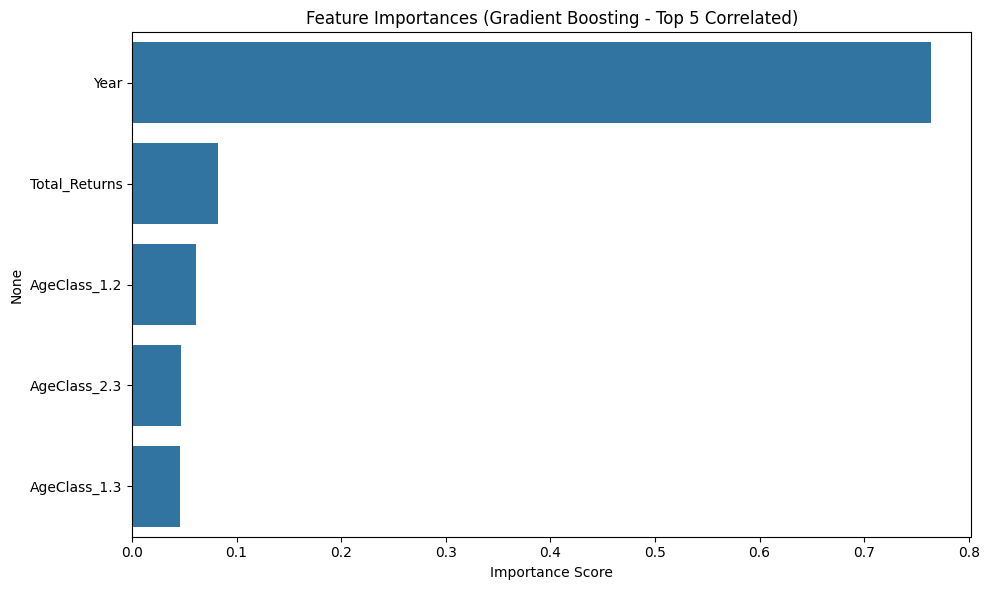

Gradient Boosting Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.3510
MSE  (Mean Squared Error):     4708289969601.53
MAPE (Mean Absolute % Error):  40.46%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate columns and keep what's needed
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-based split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Gradient Boosting Regressor ===
gbr = GradientBoostingRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=4, 
    random_state=42
)
gbr.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Gradient Boosting - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = gbr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Gradient Boosting Evaluation Metrics (Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Polynomial Regression

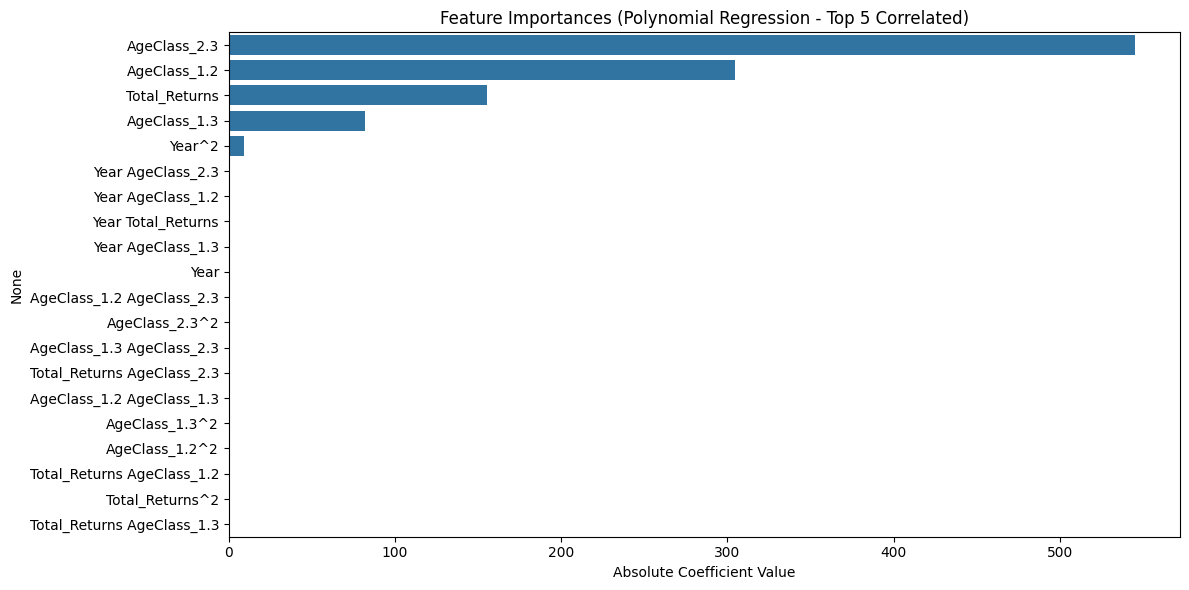

Polynomial Regression Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -8.9053
MSE  (Mean Squared Error):     34520918413847.94
MAPE (Mean Absolute % Error):  93.28%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Polynomial Features + Linear Regression ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

feature_names = poly.get_feature_names_out(X_train.columns)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# === Step 6: Plot Coefficients (All Features) ===
coefficients = pd.Series(model.coef_, index=feature_names)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(12, max(6, len(top_features) * 0.25)))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Polynomial Regression - Top 5 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = model.predict(X_test_poly)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Polynomial Regression Evaluation Metrics (Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Linear Regression

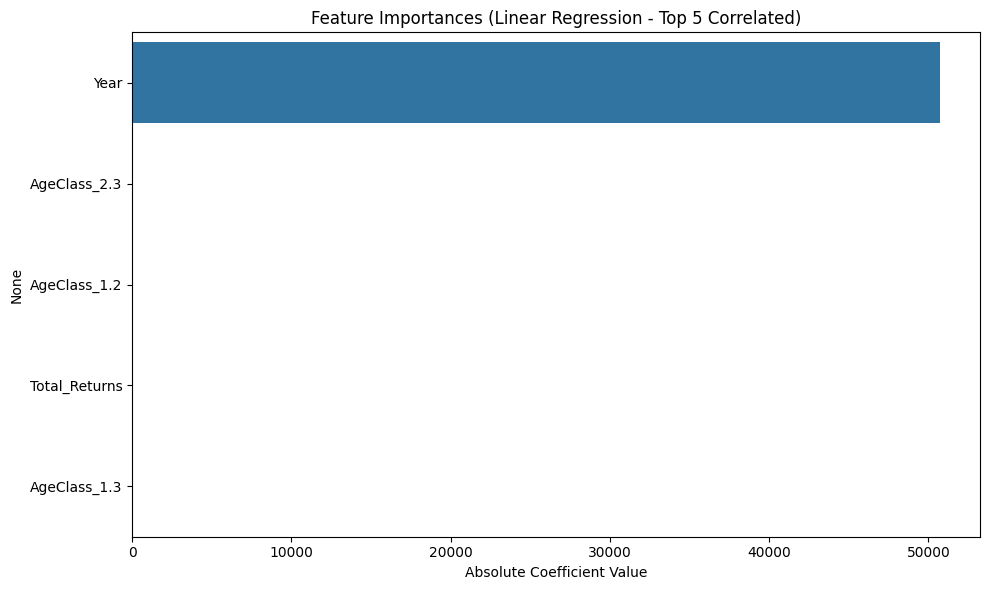

Linear Regression Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.0057
MSE  (Mean Squared Error):     3505119590088.69
MAPE (Mean Absolute % Error):  43.00%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Linear Regression ===
model = LinearRegression()
model.fit(X_train, y_train)

# === Step 6: Plot Coefficients ===
coefficients = pd.Series(model.coef_, index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Linear Regression - Top 5 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Linear Regression Evaluation Metrics (Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Random Forest model

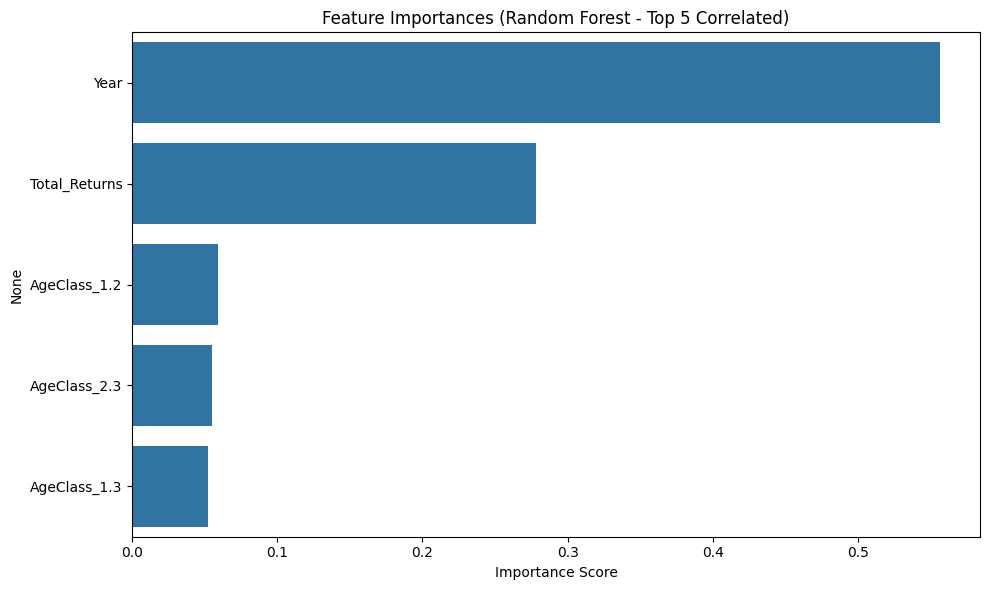

Random Forest Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              0.0279
MSE  (Mean Squared Error):     3387827771387.86
MAPE (Mean Absolute % Error):  37.83%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Random Forest Regressor ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Random Forest Evaluation Metrics (Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Random Forest Updated Code with Log Transform on Target

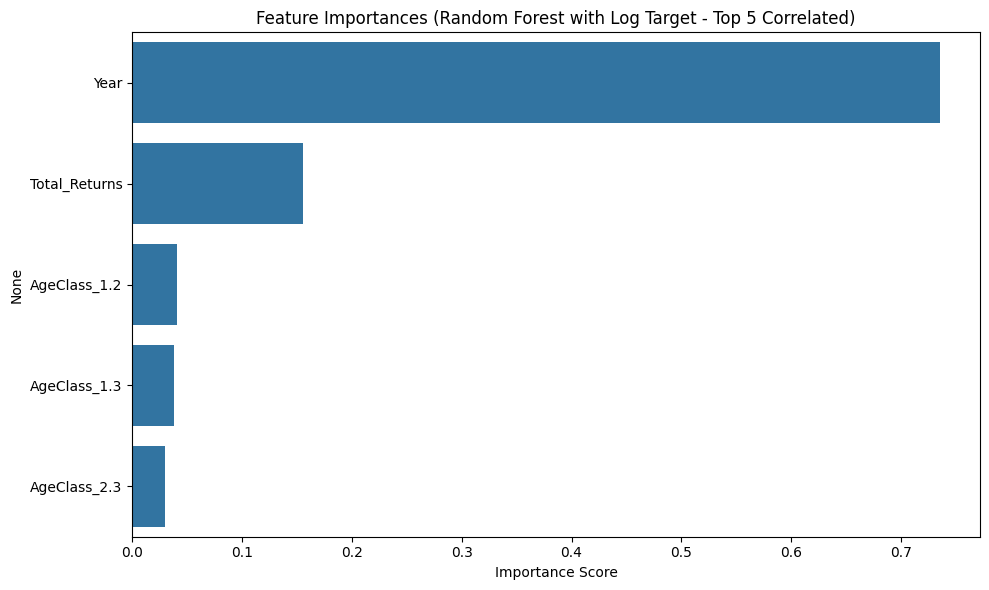

Random Forest (Log-Transformed Target, Alagnak, Top 5 Features):
R²   (R-squared):              -0.1759
MSE  (Mean Squared Error):     4098123944277.75
MAPE (Mean Absolute % Error):  38.34%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Random Forest Regressor ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train_log)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest with Log Target - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Inverse Transform ===
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

# === Step 8: Evaluate ===
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Random Forest (Log-Transformed Target, Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


 Random Forest + Log-Transform + GridSearchCV (Alagnak only):

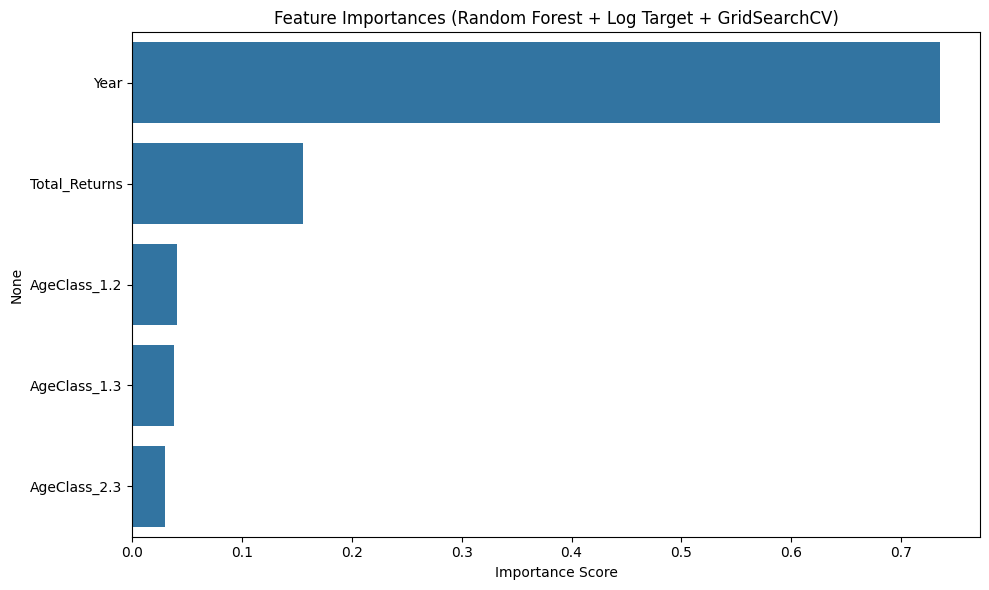

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak only):
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R²   (R-squared):              -0.1759
MSE  (Mean Squared Error):     4098123944277.75
MAPE (Mean Absolute % Error):  38.34%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split function ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: GridSearchCV for Random Forest ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid.fit(X_train, y_train_log)
best_rf = grid.best_estimator_

# === Step 6: Feature Importances ===
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target + GridSearchCV)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Inverse Log ===
y_pred_log = best_rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

# === Step 8: Evaluate ===
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Random Forest + Log-Transformed Target + GridSearchCV (Alagnak only):")
print(f"Best Params: {grid.best_params_}")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


XGBoost Regressor

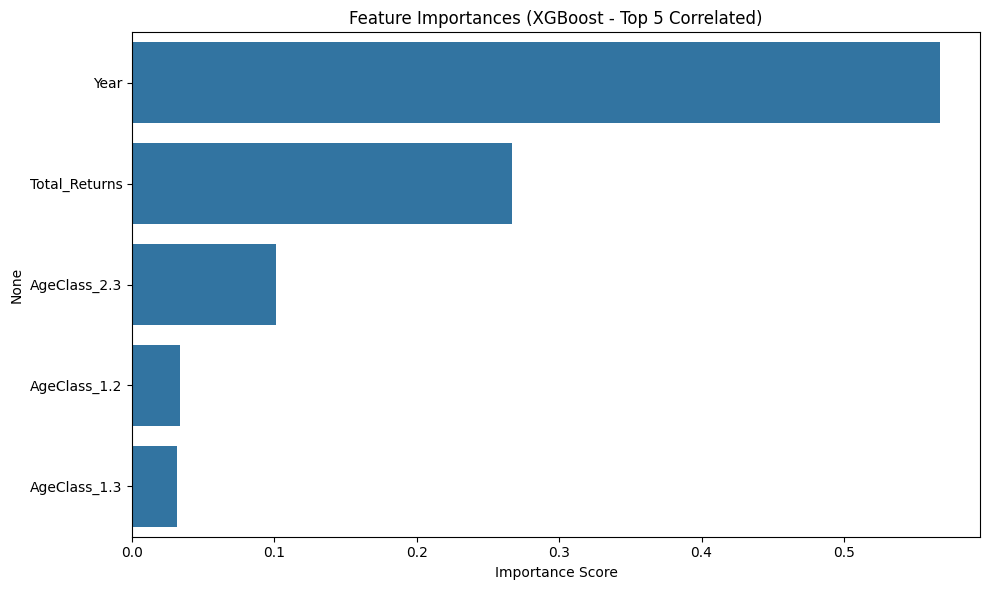

XGBoost Evaluation Metrics (Alagnak, Top 5 Features):
R²   (R-squared):              -0.5371
MSE  (Mean Squared Error):     5357056401245.84
MAPE (Mean Absolute % Error):  39.73%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 5 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top5_features = target_corr.abs().sort_values(ascending=False).head(5).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top5_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top5_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train XGBoost Regressor ===
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (XGBoost - Top 5 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGBoost Evaluation Metrics (Alagnak, Top 5 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")
